## Introduction
In this notebook we will introduce 2D numerical models with heterogeneous conductivity fields. This will allow us to illustrate the difference between mechanical dispersion at the scale of an REV and the macrodispersion that results from heterogeneity. If you haven't installed go back to the FloPy Introduction notebook.

Import the standard libraries

In [123]:
# Import the flopy library
import flopy
# Import a few additional libraries
import sys
import os
import time
# In addition to our typical libraries
import numpy as np
import matplotlib.pyplot as plt

First find where you have your MODFLOW and MT3D executables located on your system.

In [124]:
# Path to MODFLOW executable, probably called 'mf2005'
exe_name_mf = 'C:\\Hydro\\MF2005.1_12\\MF2005.1_12\\bin\\mf2005'
# Print to make sure it is formated correctly
print(exe_name_mf)
# Path to MT3D executable, probably called 'mt3dms'
exe_name_mt = 'C:\\Hydro\\mt3dusgs1.1.0\\mt3dusgs1.1.0\\bin\\mt3d-usgs_1.1.0_64'
# Print to make sure it is formated correctly
print(exe_name_mt)

C:\Hydro\MF2005.1_12\MF2005.1_12\bin\mf2005
C:\Hydro\mt3dusgs1.1.0\mt3dusgs1.1.0\bin\mt3d-usgs_1.1.0_64


Check these paths. Do they look correct for your system? If not this will lead to errors later.

Now lets name the folder(s) where we want will save our model.  

In [125]:
# This should return a path to your current working directory
current_directory = os.getcwd()
print(current_directory)

C:\Users\zahas\Dropbox\Teaching\Contaminant hydro 629\Modeling_excercises


In [126]:
# if this is not where you want to save stuff then change your directory using 'os.chdir()'
os.chdir('C:\\Users\\zahas\\Dropbox\\Teaching\\Contaminant hydro 629\\Modeling_excercises')
current_directory = os.getcwd()
print(current_directory)

C:\Users\zahas\Dropbox\Teaching\Contaminant hydro 629\Modeling_excercises


In [127]:
# now lets give a name to the directory to save data, this directory should be present in your 
# current working directory (but if it's not don't worry!)
directory_name = 'data_2D_model'
# Let's add that to the path of the current directory
workdir = os.path.join('.', directory_name)

# if the path exists then we will move on, if not then create a folder with the 'directory_name'
if os.path.isdir(workdir) is False:
    os.mkdir(workdir) 
print("Directory '% s' created" % workdir) 

Directory '.\data_2D_model' created


In [128]:
# specific folder name to save model data and output
dirname = 'macrodispersion_illustration'

Now let's assign this as our model workspace

In [129]:
# directory to save data
datadir = os.path.join('..', directory_name, 'mt3d_test', 'mt3dms')
# Model workspace and new sub-directory
model_ws = os.path.join(workdir, dirname)
print(model_ws)

.\data_2D_model\macrodispersion_illustration


Notice however that we don't yet name the folder where we will save data 'dirname'. This will be an input to our model function.

## 2D Heterogeneous Conductivity Field
In this notebook we want to model solute transport on a heterogeneous conductivity field. Make sure you have downloaded the text file 'perm_field_demo_m2.csv'. 

In [130]:
# Import permeability map example
datafile_name = 'anisotropic_perm_field_weak.csv'
# if the data is not in your current directly then add the path information
path_to_datafile = 'Contaminant-Hydrogeology-Activities\\data_for_models'
data_file_with_path = os.path.join(current_directory, data_directory, datafile_name)
print(data_file_with_path)
kdata_m2 = np.loadtxt(data_file_with_path, delimiter=',')

# otherwise simply load the data (uncomment line below)
# kdata_m2 = np.loadtxt(datafile_name, delimiter=',')

# The last two values in this text file give the field dimensions
nrow = int(kdata_m2[-2]) # number of rows / grid cells
ncol = int(kdata_m2[-1]) # number of columns (parallel to axis of core)
# Print these row and column values
print(nrow)
print(ncol)

# Crop off these values and reshape column vector to matrix
kdata_m2 = kdata_m2[0:-2]
rawk_m2 = kdata_m2.reshape(1, nrow, ncol)

# Convert permeabiltiy (in m^2) to hydraulic conductivity in cm/min
hk_weak = rawk_m2*(1000*9.81*100*60/8.9E-4)

C:\Users\zahas\Dropbox\Teaching\Contaminant hydro 629\Modeling_excercises\Contaminant-Hydrogeology-Activities\data_for_models\anisotropic_perm_field_weak.csv
20
40


In [131]:
# Import permeability map example
datafile_name = 'anisotropic_perm_field_strong.csv'
# if the data is not in your current directly then add the path information
path_to_datafile = 'Contaminant-Hydrogeology-Activities\\data_for_models'
data_file_with_path = os.path.join(current_directory, data_directory, datafile_name)
print(data_file_with_path)
kdata_m2 = np.loadtxt(data_file_with_path, delimiter=',')

# otherwise simply load the data (uncomment line below)
# kdata_m2 = np.loadtxt(datafile_name, delimiter=',')

# The last two values in this text file give the field dimensions
nrow = int(kdata_m2[-2]) # number of rows / grid cells
ncol = int(kdata_m2[-1]) # number of columns (parallel to axis of core)
# Print these row and column values
print(nrow)
print(ncol)

# Crop off these values and reshape column vector to matrix
kdata_m2 = kdata_m2[0:-2]
rawk_m2 = kdata_m2.reshape(1, nrow, ncol)

# Convert permeabiltiy (in m^2) to hydraulic conductivity in cm/min
hk_strong = rawk_m2*(1000*9.81*100*60/8.9E-4)

C:\Users\zahas\Dropbox\Teaching\Contaminant hydro 629\Modeling_excercises\Contaminant-Hydrogeology-Activities\data_for_models\anisotropic_perm_field_strong.csv
20
40


Plot the conductivity filed to make sure it looks reasonable.

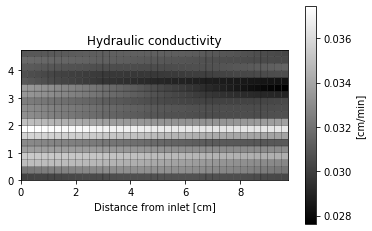

In [132]:
# Grid size (cm)
grid_size = [0.25, 0.25]
Lx = (ncol - 1) * grid_size[1]   # length of model in selected units 
Ly = (nrow - 1) * grid_size[0]   # length of model in selected units 
y, x = np.mgrid[slice(0, Ly + grid_size[0], grid_size[0]),
                slice(0, Lx + grid_size[1], grid_size[1])]

imp = plt.pcolor(x, y, hk[0,:,:], cmap='gray', edgecolors='k', linewidths=0.2)
cbar = plt.colorbar()
cbar.set_label('[cm/min]')
plt.xlabel('Distance from inlet [cm]')
plt.title('Hydraulic conductivity')
# Set axis equal and tight
plt.gca().set_aspect('equal', adjustable='box')

## 2D Model Function with Heterogeneous Conductivity Field
The first thing we do is setup the function. We will use nearly identical settings as the FloPy Introduction, but now we are providing a few input variables that can be changed everytime we call the model. The input variables are:

### Function Input:
#### directory name
    direname = 

#### period length 
Time is in selected units, the model time length is the sum of this (for steady state flow it can be set to anything). The format for multi-period input: [60., 15*60]
 
    perlen_mf = 
    
#### hydraulic conductivity
The hydraulic conductivity needs to be in the selected units (cm/s in this model) and can be either a scalar (homogeneous model) or matrix with the dimensions of the model (or vector if the model is 1D).

    hk = 
    
#### advection velocity

    v = 
    
#### dispersivity
Set the longitudinal dispersivity in selected units. What are the units again?

    al = 
    
#### number of rows

    nrow =
    
#### number of columns

    ncol = 

In [133]:
def model_2D(dirname, perlen_mf, hk, v, al, nrow, ncol):
    # Model workspace and new sub-directory
    model_ws = os.path.join(workdir, dirname)
    print(model_ws)
    
    # time units (itmuni in discretization package), unfortunately this entered differently into MODFLOW and MT3D
    # 1 = seconds, 2 = minutes, 3 = hours, 4 = days, 5 = years
    itmuni = 1 # MODFLOW
    mt_tunit = 'S' # MT3D units
    # length units (lenuniint in discretization package)
    # 0 = undefined, 1 = feet, 2 = meters, 3 = centimeters
    lenuni = 3 # MODFLOW units
    mt_lunit = 'CM' # MT3D units
    
    # number of stress periods (MF input), calculated from period length input
    nper = len(perlen_mf)
    
    # Frequency of output, If nprs > 0 results will be saved at 
    #     the times as specified in timprs; 
    nprs = 100
    # timprs (list of float): The total elapsed time at which the simulation 
    #     results are saved. The number of entries in timprs must equal nprs. (default is None).
    timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint=False)
    
    # Model information 
    nlay = 1 # number of layers
    # nrow = 1 # number of rows
    # ncol = 101 # number of columns
    delr = 0.25 # grid size in direction of Lx
    delc = 0.25 # grid size in direction of Ly, this was choosen such that the model has the same cross-sectional area as the column from the dispersion notebook example
    delv = 0.25 # grid size in direction of Lz
    laytyp = 0
    
    # length of model in selected units 
    Lx = (ncol - 1) * delr
    print("Model length is: " + str(Lx + delr) + " (check units of 'lenuni')")
    
    # hydraulic conductivity
    # Convert permeabiltiy (in m^2) to hydraulic conductivity in cm/min
    # hk = raw_km2*(1000*9.81*100*60/8.9E-4)
    # hk = 1.
    # advection velocity (function input)
    # v = 0.014
    # porosity
    prsity = 0.3
    # discharge (again in selected units)
    q = v * prsity
    
    # Flow field boundary conditions
    # boundary conditions, <0 = specified head, 0 = no flow, >0 variable head
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
    # index the inlet cell
    ibound[0, :, 0] = -1
    # index the outlet cell
    ibound[0, :, -1] = -1
    # constant head conditions
    strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
    h1 = q * Lx
    # index the inlet cell
    strt[0, :, 0] = h1
    
    # Solute transport boundary conditions
    # Concentration at inlet boundary
    c0 = 1.

    # Boundary conditions: if icbund = 0, the cell is an inactive concentration cell; 
    # If icbund < 0, the cell is a constant-concentration cell; 
    # If icbund > 0, the cell is an active concentration cell where the concentration value will be calculated.
    icbund = np.ones((nlay, nrow, ncol), dtype=np.int)
    icbund[0, :, 0] = -1 # constant-concentration cell

    # Initial conditions: concentration zero everywhere, except the inlet
    sconc = np.zeros((nlay, nrow, ncol), dtype=np.float)
    sconc[0, :, 0] = c0
    
    
    # Setup models
    # MODFLOW model name
    modelname_mf = dirname + '_mf'
    # MODFLOW package class
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    # MODFLOW model discretization package class
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper,
                                   delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
    # MODFLOW basic package class
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    # MODFLOW layer properties flow package class
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    # MODFLOW preconditioned conjugate-gradient package class
    pcg = flopy.modflow.ModflowPcg(mf)
    # MODFLOW Link-MT3DMS Package Class (this is the package for solute transport)
    lmt = flopy.modflow.ModflowLmt(mf)
    
    mf.write_input()
    mf.run_model(silent=True) # Set this to false to produce output in command window
    
    # RUN MT3dms solute tranport 
    modelname_mt = dirname + '_mt'
    # MT3DMS Model Class
    # Input: modelname = 'string', namefile_ext = 'string' (Extension for the namefile (the default is 'nam'))
    # modflowmodelflopy.modflow.mf.Modflow = This is a flopy Modflow model object upon which this Mt3dms model is based. (the default is None)
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)  
    
    
    # Basic transport package class
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, 
                             tunit=mt_tunit, lunit=mt_lunit, nprs=nprs, timprs=timprs)
    
    # mixelm is an integer flag for the advection solution option, 
    # mixelm = 0 is the standard finite difference method with upstream or central in space weighting.
    # mixelm = 1 is the forward tracking method of characteristics, this seems to result in minimal numerical dispersion.
    # mixelm = 2 is the backward tracking
    # mixelm = 3 is the hybrid method
    # mixelm = -1 is the third-ord TVD scheme (ULTIMATE)
    mixelm = 1
    
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm)
    
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al)
    ssm = flopy.mt3d.Mt3dSsm(mt)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    # Extract the output time information, convert from list to np array
    times = np.array(ucnobj.get_times())
    # Extract the 4D concentration values (t, x, y, z)
    conc = ucnobj.get_alldata()
    
    return mf, mt, times, conc

In [134]:
# model_1D(dirname, perlen_mf, v, al, mixelm)
dirname = 'anisotropic_weak'
perlen_mf = [30*60] 
v = 1
al = 0.3 # cm


mf, mt, times, conc = model_2D(dirname, perlen_mf, hk_weak, v, al, nrow, ncol)

np.shape(conc)

.\data_2D_model\anisotropic_weak
Model length is: 50.0 (check units of 'lenuni')


(101, 1, 20, 40)

Text(0.5, 1.0, 'Time: 216.0 min')

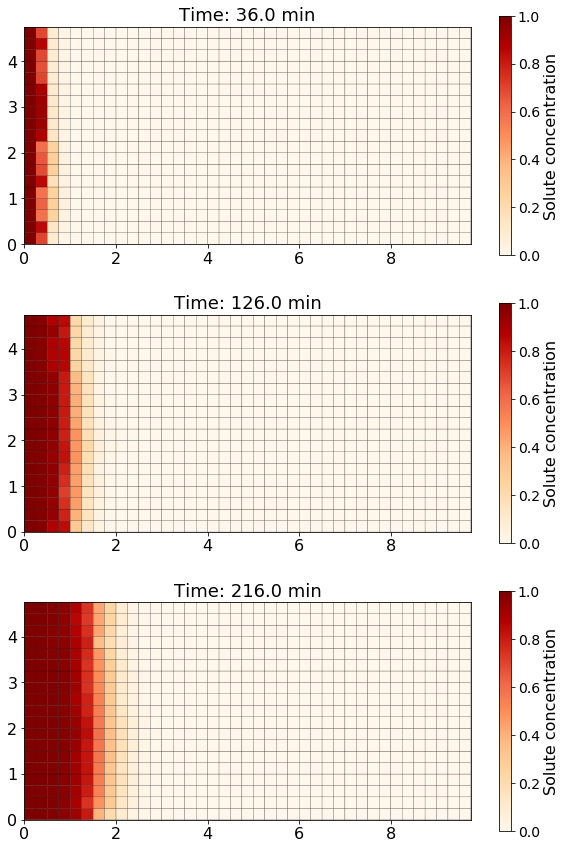

In [135]:
# First figure with concentration data
fs =16 # fontsize
fig1 = plt.figure(figsize=(10, 15))
ax0 = fig1.add_subplot(3, 1, 1, aspect='equal')
imp = plt.pcolor(x, y, conc[2,0,:,:], cmap='OrRd', edgecolors='k', linewidths=0.2)
cbar = plt.colorbar()
plt.clim(0,1) 
cbar.set_label('Solute concentration', fontsize=fs)
cbar.ax.tick_params(labelsize= (fs-2)) 
ax0.tick_params(axis='both', which='major', labelsize=fs)
plt.title('Time: %1.1f min' %times[2], fontsize=fs+2)

ax1 = fig1.add_subplot(3, 1, 2, aspect='equal')
imp = plt.pcolor(x, y, conc[7,0,:,:], cmap='OrRd', edgecolors='k', linewidths=0.2)
cbar = plt.colorbar()
plt.clim(0,1) 
cbar.set_label('Solute concentration', fontsize=fs)
cbar.ax.tick_params(labelsize= (fs-2)) 
ax1.tick_params(axis='both', which='major', labelsize=fs)
plt.title('Time: %1.1f min' %times[7], fontsize=fs+2)

ax2 = fig1.add_subplot(3, 1, 3, aspect='equal')
imp = plt.pcolor(x, y, conc[12,0,:,:], cmap='OrRd', edgecolors='k', linewidths=0.2)
cbar = plt.colorbar()
plt.clim(0,1) 
cbar.set_label('Solute concentration', fontsize=fs)
cbar.ax.tick_params(labelsize= (fs-2)) 
ax2.tick_params(axis='both', which='major', labelsize=fs)
plt.title('Time: %1.1f min' %times[12], fontsize=fs+2)